In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
# Seaborn for plotting and styling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from gendis.genetic import GeneticExtractor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff
from tools.experiments import Experiments

np.random.seed(1337)  # Random seed for reproducibility

tr_gen_options = {"samples": 23,
                  "freq": 3,
                  "reset_data": True}
dt_gen_options = {"n_test": 150}

train_test_options = {"split": 23}

df_csv_options = {"ts_class": "Bearing"}

gen_options = {"population_size": 20,
               "iterations": 20,
               "verbose": True,
               "normed": True,
               "add_noise_prob": 0.0,
               "add_shapelet_prob": 0.3,
               "wait": 10,
               "plot": True,
               "remove_shapelet_prob": 0.3,
               "crossover_prob": 0.66,
               "n_jobs": 4}

settings = {"trajectory_generator_options": tr_gen_options,
            "data_generation_options": dt_gen_options,
            "train_test_options":train_test_options,
            "define_csvs_option": df_csv_options,
            "genetic_options": gen_options}

tr_gen_options = settings["trajectory_generator_options"]
dt_gen_options = settings["data_generation_options"]
df_csvs_options = settings["define_csvs_option"]
train_test_options = settings["train_test_options"]
genetic_options = settings["genetic_options"]

first_movement = ['spiral_movement_left']
second_movement = ['random']
movements = {'first_movement': first_movement,'second_movement': second_movement}
set_movements(movements)


In [2]:
# Create files if not created
tr_gen = TrajectoryGenerator(**tr_gen_options)
tr_gen.data_generation(**dt_gen_options)
# Read in the datafiles
dex = DataExtractor()
train_df, test_df = dex.train_test_dataframes(**train_test_options)
print("The train samples length is:{0}".format(len(train_df[0] * train_test_options["split"]*2)))
print("The test samples length is:{0}\n".format(len(test_df[0] * train_test_options["split"]*2)))
dex.define_csv(**df_csvs_options)

x_train, y_train, x_test, y_test = dex.load_datasets()


Create directory 'data' 
now creating data for movement: spiral_movement_left
now creating data for movement: random
Done with generator

Reading the data files....Done reading files
The train samples length is:5520
The test samples length is:1380

Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv ...Done with train.csv ...Done with test.csv
Loading the csv files to the appropriate train and test arrays(nparrays)...Done


standardized train and test data

Starting fit in genetic extractor with:
population size:20
iterations: 20
normed: True
noise_prob: 0.0
add_shapelet_prob: 0.3
remove_shapelet_prob: 0.3
crossover_prob: 0.66



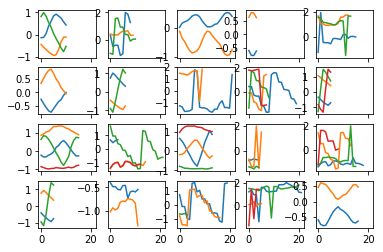

it		avg		std		max		time
1		-0.2889		0.157		-0.10022	10.9466
2		-0.1786		0.099		-0.091279	12.4337
3		-0.2116		0.093		-0.091279	12.477
4		-0.1338		0.046		-0.087643	9.8731
5		-0.1163		0.04		-0.087643	13.0684
6		-0.1304		0.032		-0.087643	12.0624
7		-0.1008		0.028		-0.067488	13.309
8		-0.1395		0.045		-0.067488	13.1422
9		-0.1206		0.034		-0.067488	14.872
10		-0.1079		0.033		-0.067488	13.126
11		-0.1202		0.036		-0.067488	15.5253
12		-0.1134		0.039		-0.067488	15.1489
13		-0.0905		0.024		-0.067488	16.3817
14		-0.0762		0.012		-0.061911	14.2699
15		-0.0702		0.008		-0.060758	15.4081
16		-0.0604		0.008		-0.052693	21.2731
17		-0.0524		0.005		-0.044539	18.4302
18		-0.0499		0.006		-0.03822	18.7138
19		-0.0506		0.006		-0.03822	20.7777
20		-0.05		0.007		-0.03822	20.8855


In [3]:
print("standardized train and test data\n")
x_train, x_test = standardize_data(x_train, x_test)
genetic_extractor = GeneticExtractor(**genetic_options)
print_genetic_param(genetic_extractor)
genetic_extractor.fit(x_train, y_train)

In [4]:
distances_train = genetic_extractor.transform(x_train)
distances_test = genetic_extractor.transform(x_test)
lr = LogisticRegression()
lr.fit(distances_train, y_train)

# Print the accuracy score on the test set
accuracy_result = accuracy_score(y_test, lr.predict(distances_test))
print('Accuracy = {}'.format(accuracy_result))

Accuracy = 1.0


In [5]:
#error analysis
for idx, x in enumerate(y_test):
    if x != lr.predict(distances_test)[idx]:
        err_ts = int(idx/2)
        print("wrong predictions found for timeseries: ",err_ts)
        fig, ax = plt.subplots()
        fig.set_size_inches(30, 20)
        ax.set_title("First Movement Plot",fontsize=20)
        file = "data/first_movement_0_"+first_movement[0]+"_"+str(err_ts)+"_2015-02-01.csv"
        df =  pd.read_csv(file)
        # Plot using Seaborn
        sns.lineplot(x='Lon', y='Lat', data=df, ax=ax,sort=False,marker="o")
        for j, point in df.iterrows():
            ax.text(point['Lon']+0.0011, point['Lat'], str(point['Bearing']),fontsize=20)
        fig, ax = plt.subplots()
        fig.set_size_inches(30, 20)
        ax.set_title("Second Movement Plot",fontsize=20)
        file = "data/second_movement_0_"+second_movement[0]+"_"+str(err_ts)+"_2015-02-01.csv"
        df =  pd.read_csv(file)
        # Plot using Seaborn
        sns.lineplot(x='Lon', y='Lat', data=df, ax=ax,sort=False,marker="o")
        for j, point in df.iterrows():
            ax.text(point['Lon']+0.0011, point['Lat'], str(point['Bearing']),fontsize=20)          
#         print(test_df[0][int(idx/2)]["Bearing"])